In [17]:
# importações necessárias para o algoritmo
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

import sklearn as skl

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

In [2]:
input_path = '../data/CE_Crateus.csv'
output_path = '../data/CE_Crateus2.csv'

In [3]:
# transforma a data em formato apropriado
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y %H%M')

In [4]:
# carrega os dados do conjunto de dados de entrada, padroniza e os salva no local desejado
def format_dataset(input_path, output_path):
    dataset = read_csv(input_path,  parse_dates=[['Data', 'Hora']], index_col=0, date_parser=parse)

    dataset.index.name = 'date'
    
    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    # substitui todos os valores NA por 0
    dataset[:].fillna(0, inplace=True)

    # mostra apenas as primeiras 5 linhas
    print(dataset.head(5))

    # salva em arquivo
    dataset.to_csv(output_path)

format_dataset(input_path, output_path)

                     Precipitacao  TempMaxima  TempMinima  Insolacao  \
date                                                                   
2015-01-01 00:00:00           0.0        35.0         0.0        5.9   
2015-01-01 12:00:00           0.0         0.0        23.7        0.0   
2015-01-02 00:00:00           0.0        35.8         0.0       10.6   
2015-01-02 12:00:00           0.0         0.0        23.0        0.0   
2015-01-03 00:00:00           0.0        31.9         0.0        4.3   

                     Evaporacao Piche  Temp Comp Media  \
date                                                     
2015-01-01 00:00:00               0.0            28.76   
2015-01-01 12:00:00               0.0             0.00   
2015-01-02 00:00:00              10.2            26.72   
2015-01-02 12:00:00               0.0             0.00   
2015-01-03 00:00:00               6.2            26.32   

                     Umidade Relativa Media  Velocidade do Vento Media  
date           

In [5]:
# carrega o conjunto de dados
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(output_path)
values = dataset.values

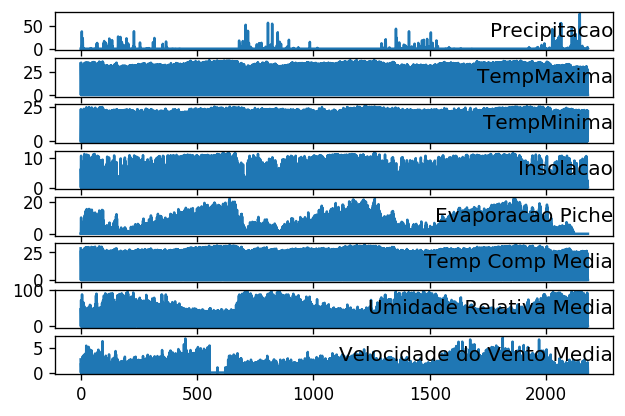

In [6]:
# plota cada coluna como um gráfico
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# converte as series para aprendizagem supervisionada
def series_to_supervised(data, n_x=24, n_y=1, dropnan=True):
    m = n_x + 1
    n = data.shape[1]
    df = DataFrame(data)
    i = 0
    df_len = len(df)
    
    samples = sample = df[0:m]
    df = df.shift(-1)
    df.dropna(inplace=True)
    samples = sample.values
    samples = samples.reshape(1,m,n)
    
    while(i < df_len-1):
        sample = df[0:m]
        if(sample.size == m*n):
            df = df.shift(-1)
            df.dropna(inplace=True)
            sample = sample.values
            sample = sample.reshape(1,m,n)
            samples = np.concatenate((samples, sample), axis=0)
        else:
            break
        i += 1
    
    np.save('../data/samples2.npy',samples)

In [8]:
# muda o tipo dos valores para ponto flutuante
values = values.astype('float32')

# normaliza a escala dos dados
scaled = np.log1p(values)

reframed = series_to_supervised(scaled)

In [9]:
reframed = np.load('../data/samples2.npy')

reframed.shape

(2157, 25, 8)

In [10]:
# separa o conjunto de dados em subconjuntos de treino e teste
values = reframed
n_train_hours = int(len(reframed) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# separa os subconjuntos de treino e teste em outros subconjuntos
# de entradas e saídas esperadas
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1725, 24, 8) (1725, 8) (432, 24, 8) (432, 8)


Train on 1725 samples, validate on 432 samples
Epoch 1/1000
 - 0s - loss: 1.2395 - mean_squared_error: 3.5629 - val_loss: 1.1652 - val_mean_squared_error: 3.2604
Epoch 2/1000
 - 0s - loss: 1.0751 - mean_squared_error: 2.7945 - val_loss: 0.9439 - val_mean_squared_error: 2.1071
Epoch 3/1000
 - 0s - loss: 0.6557 - mean_squared_error: 1.1062 - val_loss: 0.4334 - val_mean_squared_error: 0.5099
Epoch 4/1000
 - 0s - loss: 0.2556 - mean_squared_error: 0.2299 - val_loss: 0.2428 - val_mean_squared_error: 0.2919
Epoch 5/1000
 - 0s - loss: 0.1588 - mean_squared_error: 0.1412 - val_loss: 0.1910 - val_mean_squared_error: 0.2549
Epoch 6/1000
 - 0s - loss: 0.1304 - mean_squared_error: 0.1291 - val_loss: 0.1796 - val_mean_squared_error: 0.2535
Epoch 7/1000
 - 0s - loss: 0.1259 - mean_squared_error: 0.1278 - val_loss: 0.1766 - val_mean_squared_error: 0.2501
Epoch 8/1000
 - 0s - loss: 0.1244 - mean_squared_error: 0.1260 - val_loss: 0.1747 - val_mean_squared_error: 0.2472
Epoch 9/1000
 - 0s - loss: 0.1226

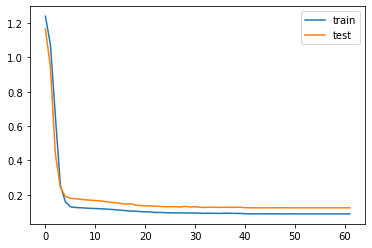

In [11]:
# arquitetura da rede
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(16, activation='relu'))   # vale a pena?
model.add(Dense(8))
model.compile(loss='mae', optimizer='adam', metrics=['mse'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
]

# modela a rede
history = model.fit(train_X, train_y, 
                    epochs=1000, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=True, 
                    callbacks=callbacks)

# plota em grafico o historico de aprendizado e treino
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [48]:
# make a prediction
yhat = model.predict(test_X)
new_test_X = test_X[:,-1,:]
new_test_X = new_test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, new_test_X[:, 1:]), axis=1)
inv_yhat = np.expm1(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
new_test_y = test_y.reshape((len(test_y), 8))
inv_y = np.concatenate((new_test_y, new_test_X[:, 1:]), axis=1)
inv_y = np.expm1(inv_y)
inv_y = inv_y[:,0]

# calculate metrics
rmse = sqrt(skl.metrics.mean_squared_error(inv_y, inv_yhat))
variance = skl.metrics.explained_variance_score(inv_y, inv_yhat)
max_error = skl.metrics.max_error(inv_y, inv_yhat)
mean_absolute_error = skl.metrics.mean_absolute_error(inv_y, inv_yhat)
median_absolute_error = skl.metrics.median_absolute_error(inv_y, inv_yhat)
r2_score = skl.metrics.r2_score(inv_y, inv_yhat)

print('Test RMSE -------------------------- {:.4}'.format(rmse))
print('Test VARIANCE ---------------------- {:.4}'.format(variance))
print('Test MAX-ERROR --------------------- {:.4}'.format(max_error))
print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(mean_absolute_error))
print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(median_absolute_error))
print('Test COEFFICIENT OF DETERMINATION -- {:.4}'.format(r2_score))

Test RMSE -------------------------- 7.507
Test VARIANCE ---------------------- -0.0001087
Test MAX-ERROR --------------------- 75.91
Test MEAN-ABSOLUTE-ERROR ----------- 1.518
Test MEDIAN-ABSOLUTE-ERROR --------- 0.002839
Test COEFFICIENT OF DETERMINATION -- -0.04254
